In [1]:
suppressMessages({
library('tidyverse')
library('ggtree')
library('glue')
library('tidytree')
library('treeio')
library('ggplot2')
library('ape')
})

In [2]:
wkdir = '/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/manuscripts/202407_autopsy/GitHub_resources'
setwd(wkdir)
source(glue("{wkdir}/scripts/tree_extra.R"))

In [3]:
message("Generate figure directories")
FIG_DIR = glue("{wkdir}/figures/")  # set up figure directory for outputs
if (!dir.exists(FIG_DIR)) {
      dir.create(FIG_DIR)
    }
message('figures will be saved in: ', FIG_DIR)

Generate figure directories

figures will be saved in: /Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/manuscripts/202407_autopsy/GitHub_resources/figures/



In [4]:
tree = read.tree(glue("{wkdir}/data/mafft.20240508.aligned.fasta.treefile"))

name = c(tree$tip.label)

In [5]:
df = as.data.frame(name) %>%
    rowwise() %>%
    mutate(dtype = ifelse(grepl("EPI", name), 'gisaid', 
                         ifelse(grepl('p45', name), 'p45', 'other')),
          
          location = ifelse(grepl("p45", name), 'p45', 
                         ifelse(grepl('FL', name), 'FL', 
                                ifelse(grepl('NY', name), 'NY', 'OTHER'))),
          temp = name) %>%
    ungroup() %>% 
    separate(temp, c('x','y','pull_date'), sep = '\\|') %>%
                select(-x, -y) %>%
                unique() %>% 
                mutate(date = as.Date(gsub("_new","", pull_date), tryFormats = c("%Y-%m-%d", "%Y/%m/%d"))) %>%
                select(-pull_date) %>%
                unique() 

temp_df = df
colnames(temp_df) = c('name','dtype','location','date') 
temp_df  = temp_df %>% select(name, date, location, dtype)

Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 1 rows [1].”


In [6]:
# Compute the depths for all nodes
all_node_depths = node.depth.edgelength(tree)
names(all_node_depths) = tree$tip.label
root_to_tip_distances_pruned = all_node_depths[tree$tip.label]

In [7]:
quartiles = quantile(root_to_tip_distances_pruned, c(0.25, 0.75))
iqr_dist = quartiles[2] - quartiles[1]

# Define your criteria for outliers using IQR, typically 1.5 * IQR
cutoff_low = quartiles[1] - 1.5 * iqr_dist
cutoff_high = quartiles[2] + 1.5 * iqr_dist
cutoff_low

25% 
0.0005317212

In [8]:
root_dist = root_to_tip_distances_pruned %>% data.frame() %>%
    rownames_to_column(var = 'V1') %>%
    mutate(name = V1) %>%
    rename("root_to_tip_distances_pruned" = ".") %>%
    separate(V1, c('x','y','pull_date'), sep = '\\|') %>%
                select(-x, -y) %>%
                unique() %>% 
                mutate(date = as.Date(gsub("_new","", pull_date), tryFormats = c("%Y-%m-%d", "%Y/%m/%d"))) %>%
                select(-pull_date) %>%
                unique() %>%
    mutate(dtype = ifelse(grepl("EPI", name), 'gisaid', 
                         ifelse(grepl('p45', name), 'p45', 'other')),
          
          location = ifelse(grepl("p45", name), 'p45', 
                         ifelse(grepl('FL', name), 'FL', 
                                ifelse(grepl('NY', name), 'NY', 'OTHER'))),
          temp = name) %>%
    drop_na()

root_dist$root_to_tip_distances_pruned = as.numeric(as.character(root_dist$root_to_tip_distances_pruned))

root_dist = root_dist %>%
            mutate(outlier = ifelse( root_to_tip_distances_pruned < cutoff_low | root_to_tip_distances_pruned > cutoff_high, 'FILT','PASS'))

Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 1 rows [1].”


In [9]:
remove_tips = df[is.na(df$date), ]

tree_pruned = drop.tip(tree, c(remove_tips$name,(root_dist %>% filter(outlier != 'PASS'))$name))

In [10]:
trda = tree_pruned %>% 
        left_join(df, by=c("label" = "name")) 

In [11]:
gisaid_samps = df %>% filter(dtype == 'gisaid') %>% drop_na(date) %>% unique() # removed the samples from the tree (see tree_pruned)

p45_samps = df %>% filter(dtype == 'p45') %>% unique()

In [12]:
gisaid_samps$temp =gisaid_samps$name

In [13]:
p = ggtree(trda, layout="circular", color = '#767676')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


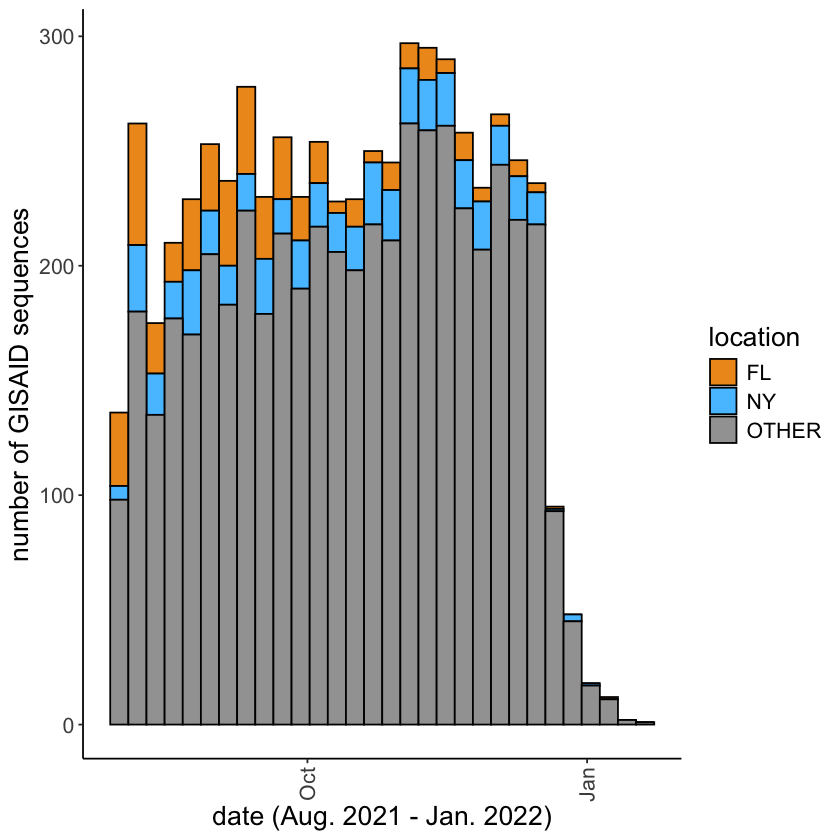

In [14]:
p0 = ggplot(gisaid_samps %>% filter(name %in% df$name & 
                              dtype != 'other'),
      aes(x=date, fill = location, position = 'stacked'))  +
    geom_histogram(color = 'black') + 
    loc_colScale_fill +
    labs(y='number of GISAID sequences', x='date (Aug. 2021 - Jan. 2022)')
p0

In [15]:
#ggsave(p0,
#       filename = glue("{FIG_DIR}/dates.gisaid.pdf"),
#       width = 7,
#       height = 5, limitsize=FALSE, useDingbats = FALSE)

In [16]:
mrca_node_id = getMRCA(tree, (df %>% filter(dtype == 'p45'))$name)
mrca_node_id

[1] 10060

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.



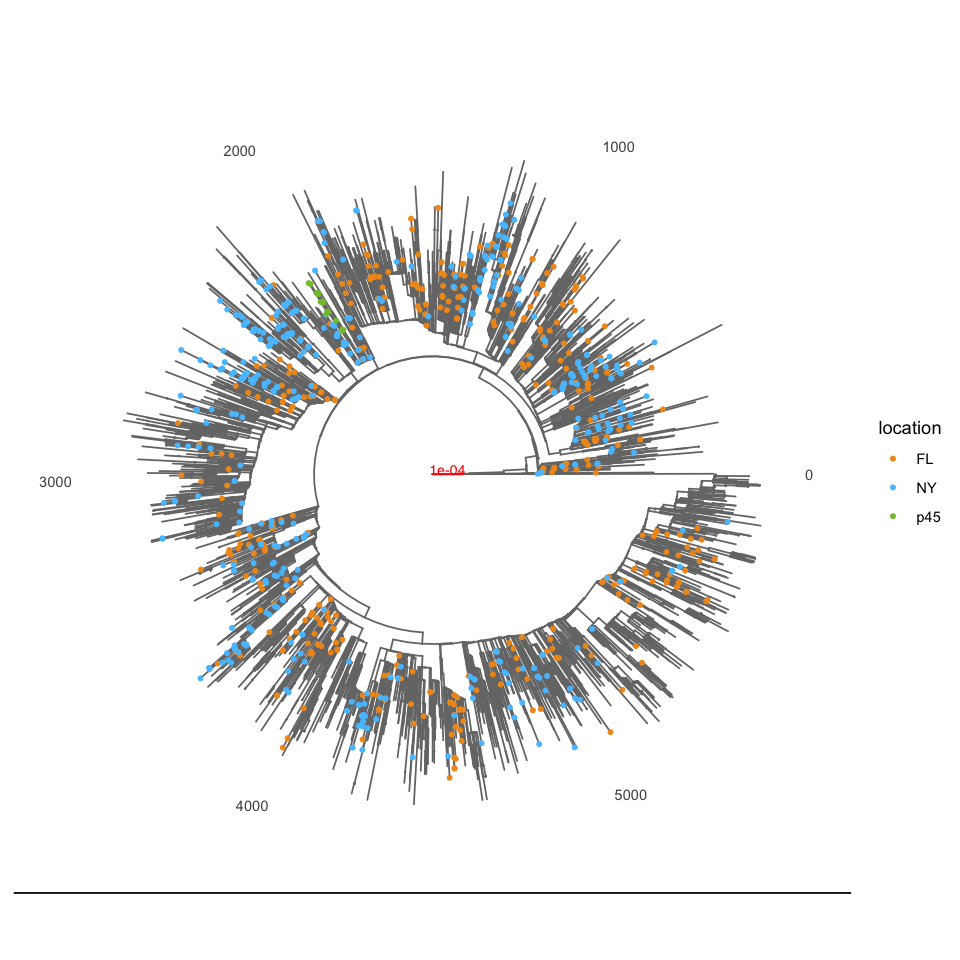

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)
p2 = p + 
    geom_tippoint(data = p %>% filter(location %in% c('NY', 'FL', 'p45')), 
                               aes(color = location), size = 1) + 
    theme_tree2() +
    loc_colScale +
    geom_treescale(x=0, y=0, fontsize=3, offset=0, color = 'red') 
p2 

In [18]:
#ggsave(p2,
#       filename = glue("{FIG_DIR}/all.tree.pdf"),
#       width = 10,
#       height = 10, limitsize=FALSE, useDingbats = FALSE)

In [19]:
tree2 = tree_subset(trda, "hCoV-19/USA/NY/2021|p45_parotid_salivary_gland|2021-11-23", levels_back=8) # used the iqtree file to find the sample furthest away from mrca 

p45_root_to_tip_dist = node.depth.edgelength(tree2@phylo)

root_dist_p45 = cbind(tree2@phylo$tip.label, p45_root_to_tip_dist) %>% data.frame() %>% mutate(name = V1) 

root_dist_p45$p45_root_to_tip_dist = as.numeric(as.character(root_dist_p45$p45_root_to_tip_dist))

root_dist_p45$mutations = root_dist_p45$p45_root_to_tip_dist * 29409 # length of wuhan-01 without utrs


root_dist_p45 = root_dist_p45 %>%
    group_by(name) %>%
    mutate(max_mutations = max(mutations)) %>% 
    select(name, max_mutations) %>%
    unique()

tree2 = tree2 %>% left_join(root_dist_p45, by=c("label" = "name")) 


! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

ℹ invalid tbl_tree object. Missing column: parent.

ℹ invalid tbl_tree object. Missing column: parent.

ℹ invalid tbl_tree object. Missing column: parent.

ℹ invalid tbl_tree object. Missing column: parent.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

Warning message in cbind(tree2@phylo$tip.label, p45_root_to_tip_dist):
“number of rows of result is not a multiple of vector length (arg 1)”


In [20]:
min(root_dist_p45$max_mutations)
max(root_dist_p45$max_mutations)

[1] 1.190329

[1] 6.830108

Warning message:
“Removed 26 rows containing missing values or values outside the scale range (`geom_label()`).”


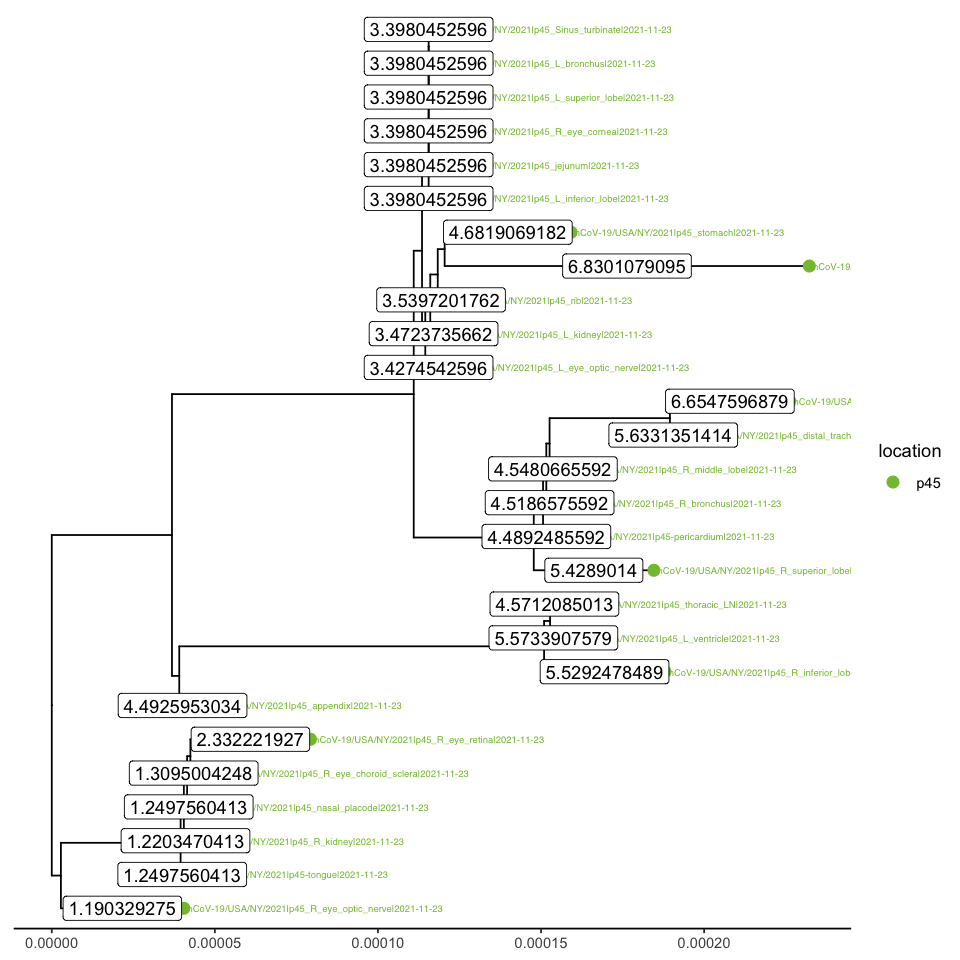

In [21]:
p3 = ggtree(tree2) +
    geom_tippoint(aes(color = location), size = 3) + 
    geom_tiplab(aes(color = location), size = 2)  + 
    theme_tree2() +
    loc_colScale  +
    geom_label(aes(x=branch, label = max_mutations))
    
p3

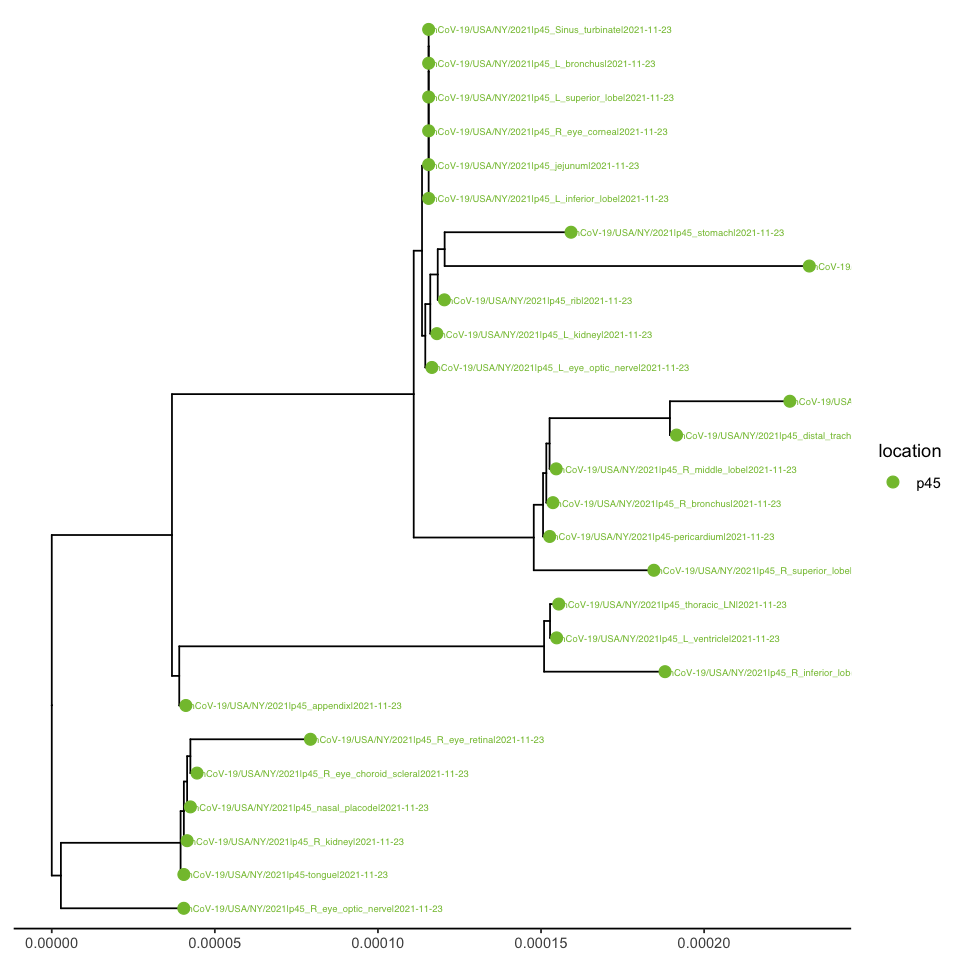

In [22]:
p3 = ggtree(tree2) +
    geom_tippoint(aes(color = location), size = 3) + 
    geom_tiplab(aes(color = location), size = 2)  + 
    theme_tree2() +
    loc_colScale 
    
p3

In [23]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: aarch64-apple-darwin20.0.0 (64-bit)
Running under: macOS 14.7.2

Matrix products: default
BLAS/LAPACK: /opt/anaconda3/envs/renv1/lib/libopenblas.0.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ape_5.8         treeio_1.22.0   tidytree_0.4.6  glue_1.7.0     
 [5] ggtree_3.6.0    lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1  
 [9] dplyr_1.1.4     purrr_1.0.2     readr_2.1.5     tidyr_1.3.1    
[13] tibble_3.2.1    ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-11      tidyselect_1.2.1   repr_1.1.7         lattice_0.22-6    
 [5] ggfun_0.1.5        colorspace_2.1-1   vctrs_0.6.5        generics_0.1.3    
 [9] htmltools_0.5.8.1  base64enc_0.1-3    utf8_1.2.4         gridGraphics_0.5-1
[13] rlang_1.1.4        pillar_1.9.0       withr_3.0.1       